## This notebook was used to explore the available data and to try out different approaches to the isochrone fitting

In [1]:
import read_mist_models as rmm
import filepaths
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp2d
import matplotlib.path as mplPath

def in_between(value,lower,upper):
    if lower > upper:
        print('lower is larger than upper')
        return False
    if value>=lower and value<=upper:
        return True
    else:
        return False

def find_nearest_neighbor(star,grid):
    def distance(star1,star2):
        return (star1[0]-star2[0])**2 + (star1[1]-star2[1])**2
    dist = distance(star,grid[-1])
    nearest_idx = 0
    for i,star2 in enumerate(grid[:-1]):
        temp = distance(star,star2)
        if temp < dist:
            nearest_idx = i
    return nearest_idx



def load_eep_tracks(min_mass=0.1,max_mass=3):
    """
    Function to load MIST eep tracks, it also writes the frame on the disk
    :param min_mass: float: minimum mass for tracks to load
    :param max_mass: float: maximum mass for tracks to load
    :return: pandas DataFrame with all the tracks concatenated and mass as index
    """
    eep_tracks = []
    eep_files = glob(filepaths.eep_tracks+'*.eep')
    fig,ax = plt.subplots()
    tracks = []
    for file in eep_files:
        eep = rmm.EEP(file,verbose=False)
        print(eep.minit)
        if eep.minit < max_mass and eep.minit > min_mass:
            masses = [eep.minit]*len(eep.eeps)
            track = pd.DataFrame(eep.eeps)
            track['mass'] = masses
            tracks.append(track)
            print('EEP track succesfully written to frame.')
    track_frame = pd.concat(tracks)
    track_frame.to_csv(filepaths.eep_tracks+'eep_frame.csv',index=False)
    return track_frame

def extract_sgb(track,threshold=.015,extension_below=0,extension_above=0,lum_max=None,teff_min=None):
    """
    Extracts the SGB from a given EEP
    :param track: DataFrame with the track
    :param threshold: float what the minimum difference between two values in log L has to be to be already on the RGB
    :return: Dataframe with EEPs only on the SGB
    """
    sgb_track = track[track['phase']==2]
    logL_diffs =np.diff(sgb_track['log_L'])
    turnoff_teff = sgb_track.iloc[np.argmax(logL_diffs>threshold)]['log_Teff']
    above_sgb = pd.DataFrame()
    if lum_max is not None:
        above_sgb = sgb_track[(sgb_track['log_Teff']<=turnoff_teff) & (sgb_track['log_L']<lum_max)]
    if teff_min is not None:
        if not above_sgb.empty:
            above_sgb = above_sgb[above_sgb['log_Teff']>teff_min]
    sgb_track = sgb_track[sgb_track['log_Teff'] > turnoff_teff]
    sgb_track = sgb_track.assign(phase = 'sgb')
    sgb_indices = sgb_track.index
    extension_num_below = int(np.ceil(len(sgb_indices) * extension_below))
    extension_num_above = int(np.ceil(len(sgb_indices) * extension_above))
    below_sgb = track.loc[sgb_indices[0] - extension_num_below:sgb_indices[0]]
    below_sgb = below_sgb.assign(phase = 'sgb extension')
    if above_sgb.empty:
        above_sgb = track.loc[sgb_indices[-1]:sgb_indices[-1] + extension_num_above]
    above_sgb = above_sgb.assign(phase='sgb extension')
    track.update(sgb_track['phase'])
    track.update(above_sgb['phase'])
    track.update(below_sgb['phase'])
    return track

def create_sgb_grid(track_frame, masses=np.concatenate((np.arange(0.7,0.9,0.05),np.arange(0.9,2.0,0.02))),extend_below = 0,extend_above=0,with_extension=False,lum_max=None,teff_min=None):
    """
    creates SGB-grid from several tracks and gives the border of this grid as matplotlib.path object
    :param track_frame: DataFrame with all the tracks
    :param masses: iterable: masses which are used to create the grid
    :return: DataFrame with SGB-only tracks, list with SGB only tracks, matplotlib.path object with border of the grid
    """
    tracks = []
    left_border = []
    right_border = []
    num_masses = len(masses)
    for i,mass in enumerate(masses):
        mass = np.round(mass,2)
        track = extract_sgb(track_frame[track_frame['mass']==mass],extension_below=extend_below,extension_above=extend_above,lum_max=lum_max,teff_min=teff_min)
        if with_extension:
            sgb = track[(track['phase'] == 'sgb') | (track['phase']=='sgb extension')]
        else:
            sgb = track[track['phase']=='sgb']
        tracks.append(track)
        left_border.append((sgb.iloc[0]['log_Teff'],sgb.iloc[0]['log_L']))
        right_border.append((sgb.iloc[-1]['log_Teff'],sgb.iloc[-1]['log_L']))
        if i==0:
            lower_border = list(zip(sgb['log_Teff'], sgb['log_L']))
        elif i==num_masses-1:
            upper_border = list(zip(sgb['log_Teff'],sgb['log_L']))
    border = left_border[1:-1]+upper_border+right_border[-1:1:-1]+lower_border[-1:1:-1]
    borderpath = mplPath.Path(border)
    return pd.concat(tracks),tracks,borderpath

def find_value(grid,grid_border,properties,stars,with_extension=False):
    """
    finds values of certain property which is given by the grid for all stars lying within the grid
    :param grid: DataFrame from SGB-only tracks
    :param grid_border: matplotlib.path object with the grid borders
    :param properties: properties which have to be found
    :param stars: dataframe with stars
    :return: dataframe containig only the subgiants, where columns with the interpolated properties are added
    """
    interpolated_grids={}
    prop_values = {}
    if with_extension:
        grid = grid[(grid['phase'] == 'sgb')|(grid['phase']=='sgb extension')]
    else:
        grid = grid[grid['phase']=='sgb']
    log_Teff = grid['log_Teff']
    log_L = grid['log_L']
    for prop in properties:
        interpolated_grids[prop] = interp2d(log_Teff,log_L,grid[prop])
        prop_values[prop] = []
    subgiants=pd.DataFrame()
    for i,star in stars.iterrows():
        log_teff_star = np.log10(star['teff_val'])
        log_L_star = np.log10(star['lum_val'])
        if with_extension or grid_border.contains_point((log_teff_star, log_L_star)):
            for prop in properties:
                prop_value = interpolated_grids[prop](log_teff_star,log_L_star)
                prop_values[prop].append(prop_value[0])
            subgiants = subgiants.append(star)
    for prop in properties:
        subgiants[prop]=prop_values[prop]
    subgiants['subgiant']=True
    return subgiants

In [ ]:
#
# track_frame = pd.read_csv(filepaths.eep_tracks+'eep_frame.csv')
# sgb_grid,sgbs,grid_borders = create_sgb_grid(track_frame)
# log_Teff = sgb_grid['log_Teff']
# log_L = sgb_grid['log_L']
# #interpolated_grid = interp2d(log_Teff,log_L,sgb_grid['log_g'])
# grid_size = 20
# teff_grid = np.linspace(np.log10(5200),np.log10(5500),grid_size)
# logL_grid = np.linspace(np.log10(10),np.log10(14),grid_size)
# grid = np.meshgrid(teff_grid,logL_grid)
# xy = (grid[0].flatten(),grid[1].flatten())
#
# cmap = plt.get_cmap('viridis')
# #logg = interpolated_grid(xy[0],xy[1])
# # print(logg)
# fig,ax = plt.subplots()
# sgb = ax.scatter(xy[0],xy[1])
#                  # c=logg,cmap=cmap, vmin=min(logg), vmax=max(logg), marker=',', s=3)
# # fig.colorbar(sgb, ax=ax)
#
# plt.show()

## Start calculation

In [2]:
catalog = pd.read_csv(filepaths.base_path+'CombinedCatalog.csv')

In [3]:
#Load tracks from individual files first time only:
#track_frame = load_eep_tracks(min_mass=0.1,max_mass=3)

#Load tracks from combined file:
track_frame = pd.read_csv(filepaths.eep_tracks+'eep_frame.csv')

### Show all tracks and position of stars

<IPython.core.display.Javascript object>


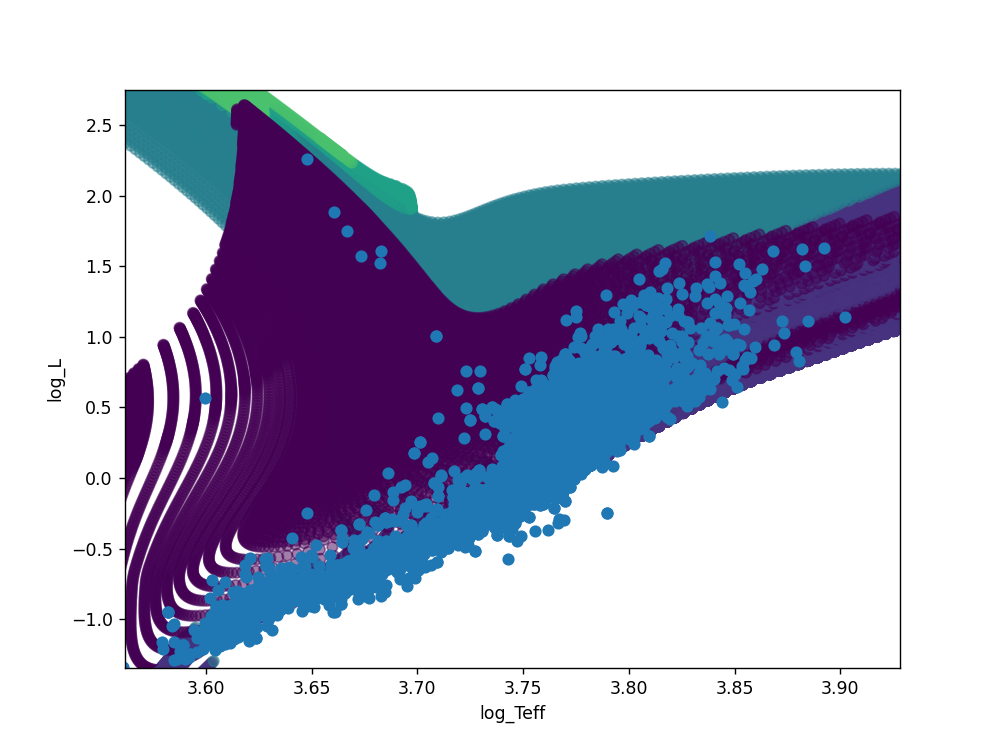

Text(0, 0.5, 'log_L')

In [86]:
prop = 'mass'
log_Teff = track_frame['log_Teff']
log_L = track_frame['log_L']
plt.scatter(log_Teff,log_L, c=track_frame['phase'], alpha=0.5)
plt.scatter(np.log10(catalog['teff_val']), np.log10(catalog['lum_val']))
plt.xlabel('log_Teff')
plt.ylabel('log_L')

In [27]:
log_Teff_star = np.log10(catalog['teff_val'])
log_L_star = np.log10(catalog['lum_val'])
ind = np.where((log_Teff > log_Teff_star.min()-0.1) & (log_Teff < log_Teff_star.max()+0.1) &
         (log_L > log_L_star.min()-0.2) & (log_L < log_L_star.max()+0.2))[0]
ind.size, log_Teff.size
index = np.copy(ind)

In [15]:

ind = index[:5000]
import time
start_time = time.time()
f = interp2d(log_Teff[ind],log_L[ind], track_frame[prop][ind])
print(time.time() - start_time)

17.07054376602173


C:\Users\Fabio Lesjak\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=71,75 m=5000 fp=0.101898 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [29]:
T_min = 3
T_max = 4
T_step = 0.1
L_min = -2
L_max = 3
L_step = 0.1

total = 0
amount_list = []
for T in np.arange(T_min, T_max, T_step):
    amount = []
    for L in np.arange(L_min, L_max, L_step):
        ind_star = np.where((log_Teff_star > T) & (log_Teff_star < T+T_step) &
         (log_L_star > L) & (log_L_star < L+L_step))[0]
        
        ind = np.where((log_Teff > T) & (log_Teff < T+T_step) &
         (log_L > L) & (log_L < L+L_step))[0]
        
        if ind_star.size > 0:
            total += ind.size
            print(ind.size)
        
        amount.extend([ind.size])
        
    amount_list.append(amount)

394
467
213
133
128
119
1
126
110
218
199
131
236
249
140
144
163
189
206
245
262
1522
2473
4385
3310
3119
0
1
154
205
427
519
598
702
774
719
470
457
473
518
514
503
533
575
561
440
135
472
589
639
760
916
1100
765
628
576
576
560
556
569
469
351
854


In [30]:
total

38540

In [5]:
def create_grid(track_frame, masses=np.concatenate((np.arange(0.7,0.9,0.05),np.arange(0.9,2.0,0.02))),extend_below = 0,extend_above=0,with_extension=False,lum_max=None,teff_min=None):
    """
    creates SGB-grid from several tracks and gives the border of this grid as matplotlib.path object
    :param track_frame: DataFrame with all the tracks
    :param masses: iterable: masses which are used to create the grid
    :return: DataFrame with SGB-only tracks, list with SGB only tracks, matplotlib.path object with border of the grid
    """
    tracks = []
    left_border = []
    right_border = []
    num_masses = len(masses)
    for i,mass in enumerate(masses):
        mass = np.round(mass,2)
        track = track_frame[track_frame['mass']==mass]
        tracks.append(track)
        left_border.append((track.iloc[0]['log_Teff'],track.iloc[0]['log_L']))
        right_border.append((track.iloc[-1]['log_Teff'],track.iloc[-1]['log_L']))
        if i==0:
            lower_border = list(zip(track['log_Teff'], track['log_L']))
        elif i==num_masses-1:
            upper_border = list(zip(track['log_Teff'],track['log_L']))
    border = left_border[1:-1]+upper_border+right_border[-1:1:-1]+lower_border[-1:1:-1]
    borderpath = mplPath.Path(border)
    return pd.concat(tracks),tracks,borderpath

In [6]:
grid,sgbs,grid_borders = create_grid(track_frame)

In [132]:


star = catalog.iloc[1]
log_teff_star = np.log10(star['teff_val'])
log_L_star = np.log10(star['lum_val'])
#f = interp2d(log_Teff,log_L,grid[prop])
#plt.scatter(log_Teff, log_L, c=grid[prop], alpha=0.1)
nearby_ind = np.where((abs(log_Teff - log_teff_star) < 0.05) & (abs(log_L - log_L_star) < 0.05) & (track_frame['phase']==0))[0]
f = interp2d(log_Teff[nearby_ind],log_L[nearby_ind], track_frame['star_mass'][nearby_ind])


C:\Users\Fabio Lesjak\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=27,23 m=511 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [137]:
nearby_ind = np.where((track_frame['phase']==0))[0]
f = interp2d(log_Teff[nearby_ind],log_L[nearby_ind], track_frame['star_mass'][nearby_ind])


C:\Users\Fabio Lesjak\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=169,182 m=29988 fp=8.426014 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [153]:
values = []
for i in range(len(catalog)):
    star = catalog.iloc[i]
    log_teff_star = np.log10(star['teff_val'])
    log_L_star = np.log10(star['lum_val'])
    m_star = f(log_teff_star, log_L_star)[0]
    values.append([log_teff_star, log_L_star, m_star])

<IPython.core.display.Javascript object>


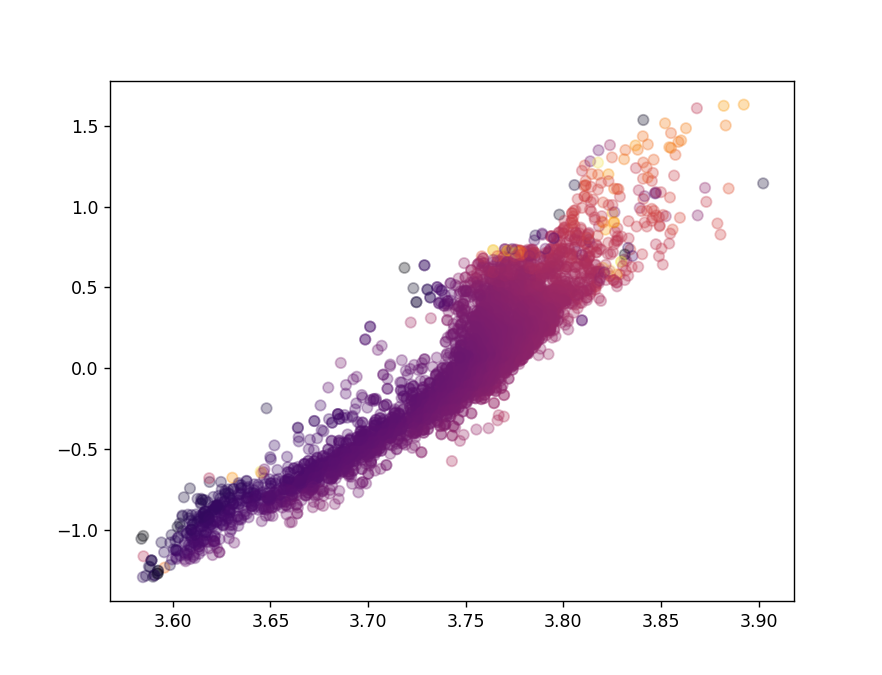

In [173]:
#values = np.array(values)

good_m = np.where((values[:,2] > 0) & (values[:,2] < 3))[0]
plt.scatter(values[:,0][good_m], values[:,1][good_m], c=values[:,2][good_m], alpha= 0.3, cmap = 'inferno')

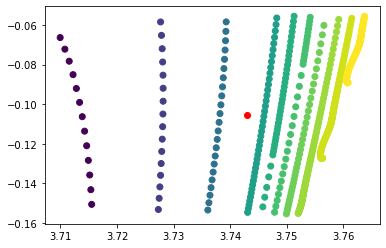

In [134]:
plt.scatter(log_Teff[nearby_ind], log_L[nearby_ind], c=track_frame['star_mass'][nearby_ind])
plt.scatter(log_teff_star, log_L_star, c='red')

<IPython.core.display.Javascript object>


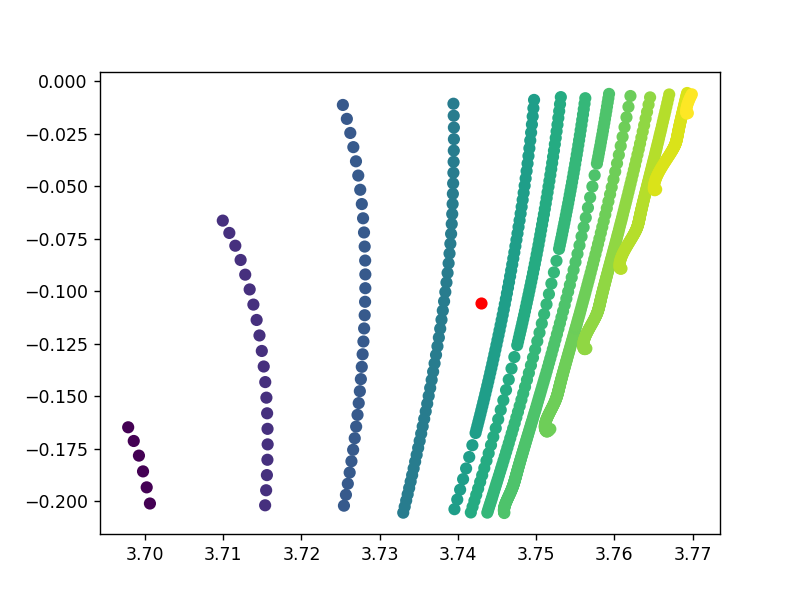

In [108]:
plt.scatter(log_Teff[nearby_ind], log_L[nearby_ind], c=[f(log_Teff[nearby_ind[i]], log_L[nearby_ind[i]]) for i in range(nearby_ind.size)])
plt.scatter(log_teff_star, log_L_star, c='red')

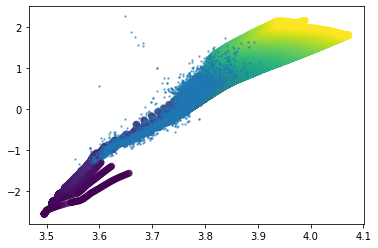

In [123]:
ms = np.where(track_frame['phase']==0)[0]
plt.scatter(log_Teff[ms],log_L[ms], c=track_frame['star_mass'][ms], alpha=0.5)
plt.scatter(np.log10(catalog['teff_val']), np.log10(catalog['lum_val']), s=2, alpha=0.5)

In [72]:
[f(log_Teff[nearby_ind[i]], log_L[nearby_ind[i]]) for i in range(nearby_ind.size)]

array([0.14794982])

(array([ 13.,  16.,   0.,  23.,   0.,  40.,  39.,  69., 106., 205.]),
 array([0.74953273, 0.77657919, 0.80362564, 0.8306721 , 0.85771856,
        0.88476501, 0.91181147, 0.93885793, 0.96590439, 0.99295084,
        1.0199973 ]),
 <BarContainer object of 10 artists>)

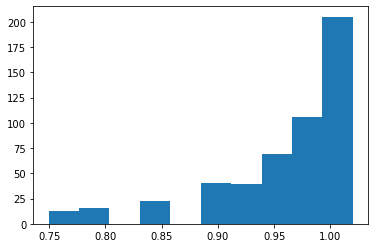

In [136]:
plt.hist(track_frame['star_mass'][nearby_ind])

In [36]:
def find_value(grid,grid_border,properties,stars):
    """
    finds values of certain property which is given by the grid for all stars lying within the grid
    :param grid: DataFrame from SGB-only tracks
    :param grid_border: matplotlib.path object with the grid borders
    :param properties: properties which have to be found
    :param stars: dataframe with stars
    :return: dataframe containig only the subgiants, where columns with the interpolated properties are added
    """
    interpolated_grids={}
    prop_values = {}
    log_Teff = grid['log_Teff']
    log_L = grid['log_L']
    for prop in properties:
        interpolated_grids[prop] = interp2d(log_Teff,log_L,grid[prop])
        prop_values[prop] = []
    result=pd.DataFrame()
    print(1)
    for i,star in stars.iterrows():
        log_teff_star = np.log10(star['teff_val'])
        log_L_star = np.log10(star['lum_val'])
        if grid_border.contains_point((log_teff_star, log_L_star)):
            for prop in properties:
                prop_value = interpolated_grids[prop](log_teff_star,log_L_star)
                prop_values[prop].append(prop_value[0])
            result = result.append(star)
        print(2)
    for prop in properties:
        result[prop]=prop_values[prop]
    return result

In [19]:
star = catalog.iloc[0]
log_teff_star = np.log10(star['teff_val'])
log_L_star = np.log10(star['lum_val'])

In [20]:
grid_borders.contains_point((log_teff_star, log_L_star))

True

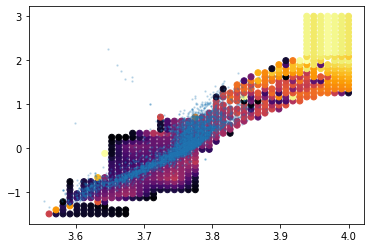

In [193]:
values = []
for teff in np.linspace(3.5,4,50):
    for lum in np.linspace(-1.5,3,50):
        mass = f(teff, lum)[0]
        values.append([teff, lum, mass])
values = np.array(values)

good_m = np.where((values[:,2] > 0) & (values[:,2] < 3))[0]
plt.scatter(values[:,0][good_m], values[:,1][good_m], c=values[:,2][good_m], alpha= 1, cmap = 'inferno')

plt.scatter(np.log10(catalog['teff_val']), np.log10(catalog['lum_val']), s=2, alpha=0.2)

In [190]:
# import pickle

# with open('fit_mass_MS.pickle', 'wb') as handle:
#     pickle.dump(f, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('fit_mass_MS.pickle', 'rb') as handle:
#     f_loaded = pickle.load(handle)

In [194]:
catalog

,Name,distance,source_id,designation,ra,dec,l,b,ecl_lon,ecl_lat,...,Seq,SpType,BV,RAdeg,DEdeg,VMAG,Plx,Smean,Smed,logRpHK
0,HIP46417,0.001890,1144584084028819072,Gaia DR2 1144584084028819072,141.984319,80.578337,131.621850,32.803868,104.893860,59.882975,...,1500,tmp,1.205000,NaN,NaN,7.464442,43.54,NaN,0.717429,-4.659683
1,HIP9269,0.001842,304991163902854784,Gaia DR2 304991163902854784,29.778893,33.208169,138.873938,-27.559835,39.522365,19.706076,...,2769,G9V,0.773000,29.776931,33.210538,5.190105,40.74,0.156500,0.156000,-5.061782
2,HIP10938,0.001440,4699984228137260416,Gaia DR2 4699984228137260416,35.220068,-64.211680,287.936855,-50.232362,340.198581,-67.805984,...,3911,K6.5 V (k),1.370001,NaN,NaN,8.003982,NaN,1.022000,NaN,-4.689335
3,HIP55210,0.003484,3786697056556771584,Gaia DR2 3786697056556771584,169.595151,-5.067952,264.504129,50.727909,172.446457,-8.777995,...,3275,G8V,0.732000,169.589775,-5.066936,5.579102,45.48,0.176353,0.175000,-4.928190
4,HD190422,0.000172,6472858766996632704,Gaia DR2 6472858766996632704,301.896348,-55.015862,343.020297,-32.685813,291.413171,-33.922734,...,1232,F9VCH-0.4,0.530000,301.896133,-55.016100,4.431378,43.08,0.333000,NaN,-4.318952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5797,HD154363,0.003154,4364527594190739456,Gaia DR2 4364527594190739456,256.266849,-5.068149,15.367532,20.888986,255.628589,17.688612,...,6404,K5V,1.100000,256.266379,-5.063742,7.541948,92.98,0.338679,0.397990,-4.835729
5798,HIP35136,0.000813,974887555341533440,Gaia DR2 974887555341533440,108.959104,47.239163,170.343616,23.514837,104.054056,24.720642,...,376,F9V,0.576000,108.958805,47.240416,4.405640,59.31,0.161000,0.161000,-4.863280
5799,HD135101A,0.002860,1212385193677160832,Gaia DR2 1212385193677160832,228.178452,19.287303,26.946963,56.724144,219.235658,35.650903,...,1538,tmp,0.680000,NaN,NaN,4.112861,30.66,0.141547,0.147015,-5.033304
5800,HD17152,0.001113,5076927085068494080,Gaia DR2 5076927085068494080,41.120461,-24.416754,213.222315,-64.459655,29.302833,-38.130865,...,4291,G8V,0.772000,NaN,NaN,5.168215,22.68,NaN,0.150000,-5.095222


### Where is main sequence

Text(0, 0.5, 'Luminosity')

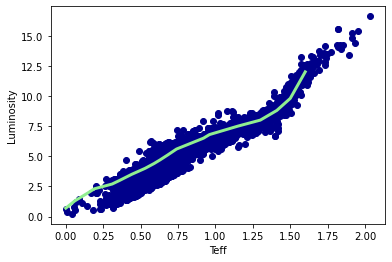

In [5]:
#main sequence parameters from Gray 2005 Table B1
ms_bv = np.array([0, 0.06, 0.14, 0.19, 0.31, 0.36, 0.44, 0.53, 0.59, 0.63, 0.68, 0.74, 0.82, 0.92, 0.96, 1.15, 1.3, 1.41, 1.5, 1.6])
ms_mv = np.array([0.7, 1.3, 1.9, 2.3, 2.7, 3, 3.5, 4, 4.4, 4.7, 5.1, 5.6, 6, 6.5, 6.8, 7.5, 8, 8.8, 9.8, 12])

plt.scatter(catalog.BV, catalog.VMAG, c='darkblue')
plt.plot(ms_bv, ms_mv, c='lightgreen', linewidth=3) 
plt.xlabel('Teff')
plt.ylabel('Luminosity')

Text(0, 0.5, 'V Magnitude')

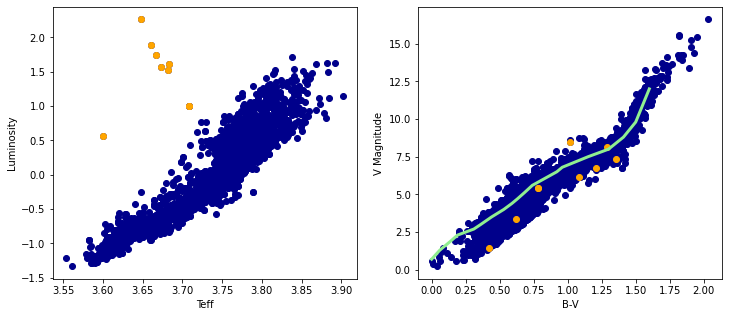

In [6]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
outliers = np.where((np.log10(catalog.teff_val) < 3.71) & (np.log10(catalog.lum_val) > 0.5))[0]
ax[0].scatter(np.log10(catalog.teff_val), np.log10(catalog.lum_val), c='darkblue')
ax[0].scatter(np.log10(catalog.teff_val[outliers]), np.log10(catalog.lum_val[outliers]), c='orange')
ax[0].set_xlabel('Teff')
ax[0].set_ylabel('Luminosity')

ax[1].scatter(catalog.BV, catalog.VMAG, c='darkblue')
ax[1].plot(ms_bv, ms_mv, c='lightgreen', linewidth=3)
# plt.plot(ms_bv, ms_mv+1, c='red') 
# plt.plot(ms_bv, ms_mv-1, c='red') 
ax[1].scatter(catalog.BV[outliers], catalog.VMAG[outliers], c='orange')
ax[1].set_xlabel('B-V')
ax[1].set_ylabel('V Magnitude')

There are some outliers in the Teff L plot, but they are no outliers in the bv vmag plot. Save these to a file.

In [11]:
catalog.loc[outliers].to_csv(filepaths.base_path+'Outliers.csv')

#### Where are the MS tracks?

Text(0, 0.5, 'Luminosity')

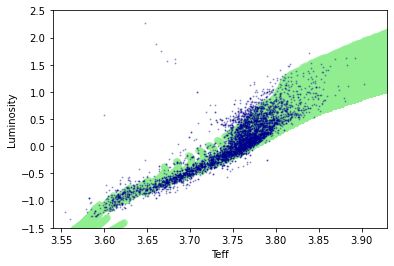

In [256]:
ms_track = np.where(track_frame.phase==0)[0]
plt.scatter(track_frame.log_Teff[ms],track_frame.log_L[ms], c='lightgreen', alpha=0.5)
plt.scatter(np.log10(catalog.teff_val), np.log10(catalog.lum_val), c='darkblue',alpha=0.3, s=1)
plt.xlim(3.54, 3.93)
plt.ylim(-1.5, 2.5)
plt.xlabel('Teff')
plt.ylabel('Luminosity')

Some of the stars are not in the region covered by the MS tracks. This makes it difficult to fit the parameters for them.

# Use the MIST isochrones instead of EEP tracks

In [3]:
catalog = pd.read_csv(filepaths.base_path+'CombinedCatalog.csv')

#Load isochrones from UBVRI file including Gaia bandpasses
path_UBVRI = filepaths.base_path+'Isochrones/MIST_v1.2_vvcrit0.0_UBVRIplus/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd'
mist_UBVRI = rmm.ISOCMD(path_UBVRI)

mist_UBVRI_df = [pd.DataFrame(isochrone) for isochrone in mist_UBVRI.isocmds]
isoc_UBVRI = pd.concat(mist_UBVRI_df, ignore_index=True)

#Load isochrones with basic parameters
path_basic = filepaths.base_path+'Isochrones/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_basic.iso'
mist_basic = rmm.ISO(path_basic)

mist_basic_df = [pd.DataFrame(isochrone) for isochrone in mist_basic.isos]
isoc_basic = pd.concat(mist_basic_df, ignore_index=True)

#merge the two catalogs
isoc = pd.merge(isoc_UBVRI, isoc_basic)

Reading in: D:/Master/Minijob/Isochrones/MIST_v1.2_vvcrit0.0_UBVRIplus/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
Reading in: D:/Master/Minijob/Isochrones/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_basic.iso


In [4]:
isoc_MS = (isoc.phase == 0)
isoc_bound = ((isoc.log_Teff > 3.54)&(isoc.log_Teff < 3.93))

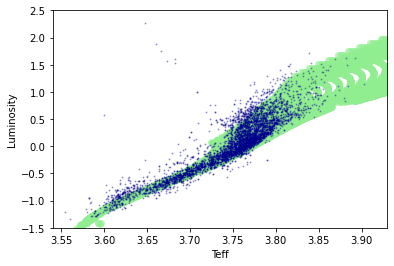

In [112]:
plt.scatter(isoc.log_Teff[isoc_MS], isoc.log_L[isoc_MS], c='lightgreen', alpha=0.5)
plt.scatter(np.log10(catalog.teff_val), np.log10(catalog.lum_val), c='darkblue',alpha=0.3, s=1)
plt.xlim(3.54, 3.93)
plt.ylim(-1.5, 2.5)
plt.xlabel('Teff')
plt.ylabel('Luminosity');

There are about 8000 isochrone point in this region

In [113]:
isoc.columns

Index(['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass',
       'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U',
       'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', '2MASS_J',
       '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 'Hipparcos_Hp',
       'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev',
       'Gaia_RP_DR2Rev', 'Gaia_G_MAW', 'Gaia_BP_MAWb', 'Gaia_BP_MAWf',
       'Gaia_RP_MAW', 'TESS', 'phase', 'star_mdot', 'he_core_mass',
       'c_core_mass', 'log_LH', 'log_LHe', 'log_R', 'surface_h1',
       'surface_he3', 'surface_he4', 'surface_c12', 'surface_o16',
       'log_center_T', 'log_center_Rho', 'center_gamma', 'center_h1',
       'center_he4', 'center_c12'],
      dtype='object')

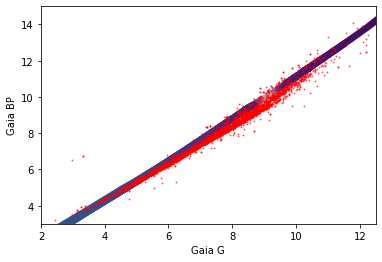

In [205]:
plt.scatter(isoc.Gaia_G_MAW[isoc_MS], isoc.Gaia_BP_MAWb[isoc_MS], c=isoc.log_Teff[isoc_MS], alpha=0.1)
plt.scatter(catalog.phot_g_mean_mag, catalog.phot_bp_mean_mag, c='red',alpha=0.5, s=1)
plt.xlim(2, 12.5)
plt.ylim(3, 15)
plt.xlabel('Gaia G')
plt.ylabel('Gaia BP');

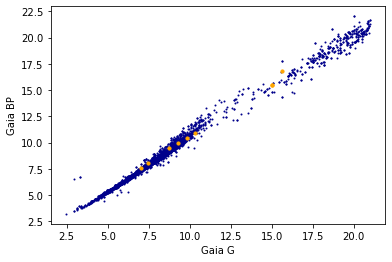

In [178]:
#The ones not fitting with the Gaia g vs bp plot
outliers_Gaia = np.where(catalog.phot_g_mean_mag > 12)[0]

#the ones that dont have a teff value given
outliers_noTeff = np.where(pd.isnull(catalog.teff_val))[0]

#the ones that are outliers in the teff-L plot for the main sequence
outliers_MS = np.where((np.log10(catalog.teff_val) < 3.71) & (np.log10(catalog.lum_val) > 0.5))[0]

#plt.scatter(np.log10(catalog.teff_val), np.log10(catalog.lum_val), c='darkblue',alpha=0.3, s=1)
#plt.scatter(np.log10(catalog.teff_val)[outliersGaia], np.log10(catalog.lum_val)[outliersGaia], c='orange',alpha=1, s=10)

plt.scatter(catalog.phot_g_mean_mag, catalog.phot_bp_mean_mag, c='darkblue',alpha=1, s=1)
plt.scatter(catalog.phot_g_mean_mag[outliers_MS], catalog.phot_bp_mean_mag[outliers_MS], c='orange',alpha=1, s=10)

plt.xlabel('Gaia G')
plt.ylabel('Gaia BP');

In [8]:
#The ones not fitting with the Gaia g vs bp plot
outliers_Gaia = (catalog.phot_g_mean_mag > 12)

#the ones that dont have a teff value given
outliers_noTeff = (pd.isnull(catalog.teff_val))

np.where(outliers_Gaia & outliers_noTeff)[0].size, np.where(outliers_Gaia)[0].size

(405, 513)

There are 513 Gaia outliers (from total of 5802 points), and 405 of the outliers have no Teff value. The outliers of the main sequence are no outliers in the Gaia G-BP plot.

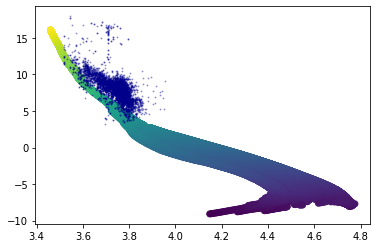

In [197]:
plt.scatter(isoc.log_Teff[isoc_MS], isoc.Gaia_BP_DR2Rev[isoc_MS], c=isoc.Gaia_BP_DR2Rev[isoc_MS], alpha=1)
plt.scatter(np.log10(catalog.teff_val), catalog.phot_bp_mean_mag, c='darkblue',alpha=0.3, s=1)

### Use two colors as parameters

In [84]:
plt.scatter(isoc.Gaia_BP_DR2Rev[isoc_MS]-isoc.Gaia_G_DR2Rev[isoc_MS], isoc.Gaia_G_DR2Rev[isoc_MS]-isoc.Gaia_RP_DR2Rev[isoc_MS], c=isoc.log_Teff[isoc_MS], alpha=0.1)

plt.scatter(catalog.bp_g, catalog.g_rp+0.05, c='red',alpha=0.5, s=1)
plt.scatter(catalog.bp_g[outliers_noTeff], catalog.g_rp[outliers_noTeff], c='white',alpha=1, s=1)
# plt.xlim(0, .7)
# plt.ylim(0.1, 0.8)
plt.xlabel('BP - G')
plt.ylabel('G - RP');

<IPython.core.display.Javascript object>

Catalog values consistently below isochrone values...try to shift upwards?

#### Try fitting in a small region to test if it works

In [51]:
BP_G_isoc = isoc.Gaia_BP_DR2Rev-isoc.Gaia_G_DR2Rev
G_RP_isoc = isoc.Gaia_G_DR2Rev-isoc.Gaia_RP_DR2Rev
Teff_isoc =isoc.log_Teff

In [21]:
section = np.where((BP_G_isoc > 0.5) & (BP_G_isoc < 1) & isoc_MS)[0]
f = interp2d(BP_G_isoc[section],G_RP_isoc[section], Teff_isoc[section])

C:\Users\Fabio Lesjak\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=47,46 m=1940 fp=0.000016 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [69]:
catalog_section = np.where((catalog.bp_g > 0.5) & (catalog.bp_g < 1))[0]
result = np.ones(0)
for i in catalog_section:  
    result = np.append(result, f(catalog.bp_g[i], catalog.g_rp[i]+0.03))

<IPython.core.display.Javascript object>


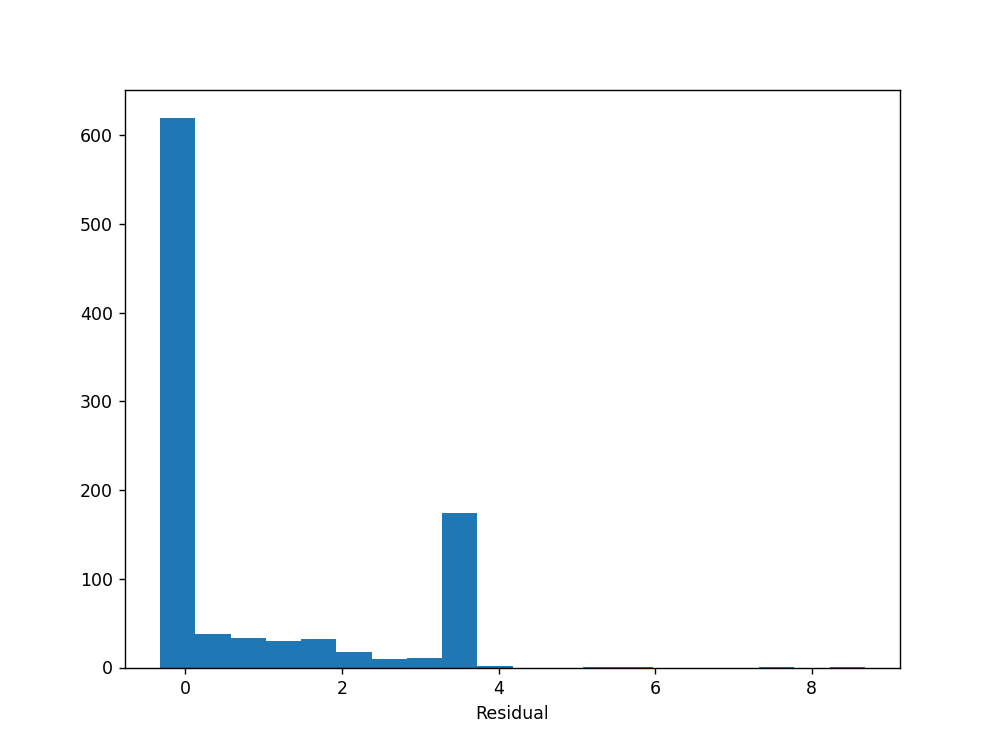

Text(0.5, 0, 'Residual')

In [70]:
plt.hist(np.log10(catalog.teff_val)[catalog_section]-result, 20);
plt.xlabel('Residual')

In [72]:
plt.scatter(isoc.Gaia_BP_DR2Rev[isoc_MS]-isoc.Gaia_G_DR2Rev[isoc_MS], isoc.Gaia_G_DR2Rev[isoc_MS]-isoc.Gaia_RP_DR2Rev[isoc_MS], c=isoc.log_Teff[isoc_MS], alpha=0.1)

plt.scatter(catalog.bp_g, catalog.g_rp, c='red',alpha=0.5, s=1)

zeroT_fitted = np.where(result == 0)[0]
plt.scatter(np.array(catalog.bp_g[catalog_section])[zeroT_fitted], np.array(catalog.g_rp[catalog_section])[zeroT_fitted]+0.03, c='yellow',alpha=0.5, s=5)
plt.xlim(0.5, 1)
plt.ylim(0, 1.5)
plt.xlabel('BP - G')
plt.ylabel('G - RP');

<IPython.core.display.Javascript object>

#### Calculate T_eff by finding nearest neighbor in isochrones

In [199]:
BP_G_isoc = isoc.Gaia_BP_DR2Rev-isoc.Gaia_G_DR2Rev
G_RP_isoc = isoc.Gaia_G_DR2Rev-isoc.Gaia_RP_DR2Rev
Teff_isoc =isoc.log_Teff
isoc_MS = (isoc.phase == 0)

T_eff_NN = []
for star_ind in range(len(catalog)):
    if (pd.isnull(catalog.bp_g[star_ind]) or pd.isnull(catalog.g_rp[star_ind])):
        T_eff_NN.append(np.nan)
    else:
        distance = (catalog.bp_g[star_ind] - BP_G_isoc[isoc_MS])**2 + (catalog.g_rp[star_ind] - G_RP_isoc[isoc_MS])**2
        nearest_ind = np.argmin(distance)
        Teff_value = np.array(Teff_isoc[isoc_MS])[nearest_ind]
        T_eff_NN.append(Teff_value)

<IPython.core.display.Javascript object>


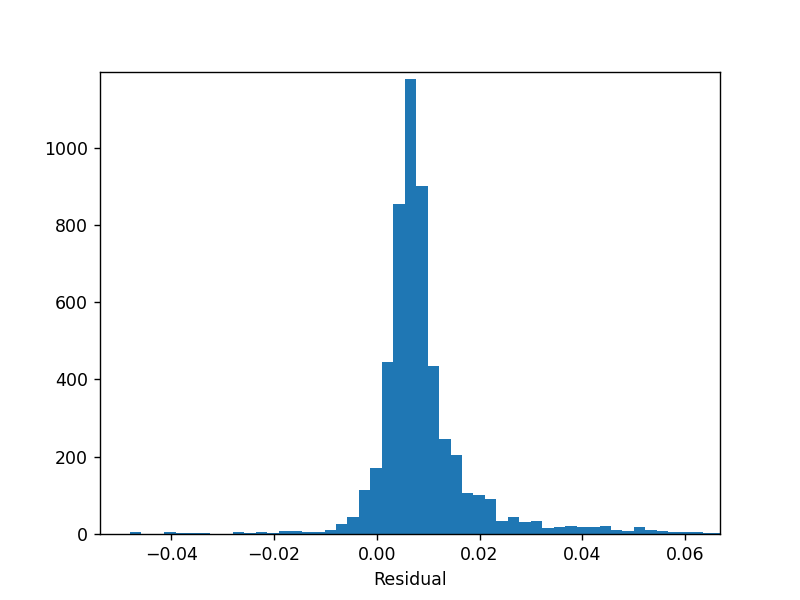

Text(0.5, 0, 'Residual')

In [202]:
plt.hist(np.log10(catalog.teff_val)-T_eff_NN, 500);
plt.xlabel('Residual')

<IPython.core.display.Javascript object>


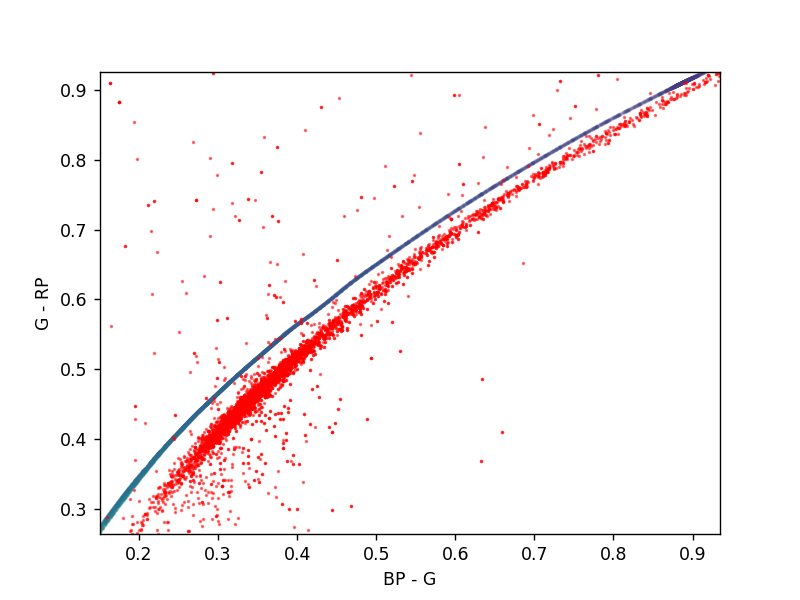

In [276]:
plt.scatter(BP_G_isoc[isoc_MS], G_RP_isoc[isoc_MS], c=Teff_isoc[isoc_MS], alpha=0.1, s=2)

plt.scatter(catalog.bp_g, catalog.g_rp, c='red',alpha=0.5, s=1)
#plt.scatter(catalog.bp_g[outliers_noTeff], catalog.g_rp[outliers_noTeff], c='white',alpha=1, s=1)
# plt.xlim(0, .7)
# plt.ylim(0.1, 0.8)
plt.xlabel('BP - G')
plt.ylabel('G - RP');

Fit a polynomial to the isochrones to define outliers of catalog

(-0.5, 2.0)

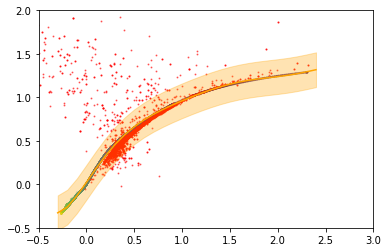

In [141]:
isoc_fit = np.polyfit(BP_G_isoc[isoc_MS], G_RP_isoc[isoc_MS], 7)
isoc_p = np.poly1d(isoc_fit)
interval_width = 0.2

plt.scatter(BP_G_isoc[isoc_MS], G_RP_isoc[isoc_MS], c=Teff_isoc[isoc_MS], alpha=0.1, s=2)
plt.scatter(catalog.bp_g, catalog.g_rp, c='red',alpha=0.5, s=1)
x = np.arange(-0.3,2.5,0.1)
plt.plot(x,isoc_p(x), c='orange')

plt.fill_between(x, isoc_p(x)-interval_width, isoc_p(x)+interval_width, color='orange', alpha=0.3)

plt.xlim(-0.5, 3)
plt.ylim(-0.5, 2)

In [159]:
near_isoc = (abs(isoc_p(catalog.bp_g) - catalog.g_rp) < interval_width)
np.array(T_eff_NN)[near_isoc == False]

array([       nan,        nan, 3.69949443,        nan, 4.352085  ,
       3.92513645,        nan, 3.55145818, 4.11685268, 4.32351533,
       4.36653322,        nan,        nan,        nan,        nan,
       4.43033744,        nan, 4.53993373,        nan, 4.40430425,
              nan, 4.27553064, 4.43951151, 3.92513645,        nan,
              nan,        nan,        nan,        nan,        nan,
       4.31831262,        nan, 3.4805904 , 3.93095409,        nan,
       4.35117881, 3.91350136, 3.94840689,        nan, 3.91350136,
       3.93953955, 3.49223041, 4.18385492, 4.25919618, 3.54156195,
       3.93095409, 4.4528715 , 3.94768471, 4.33764952, 4.33327219,
              nan, 4.28631427, 4.29163992, 4.33421778, 4.12841252,
       4.30181138, 4.1341861 , 3.94840689, 3.66870722,        nan,
       4.45985435, 4.39971549,        nan, 4.35183859, 4.06468894,
       3.92513645, 4.3181228 ,        nan, 4.33327219, 3.52276751,
       4.06468894,        nan,        nan, 4.26147658, 4.27553

In [154]:
np.array(T_eff_NN)[near_isoc]


array([4.31823036, 3.94165095, 4.34459218, ..., 4.5479602 , 3.4758059 ,
       4.11816264])

<IPython.core.display.Javascript object>


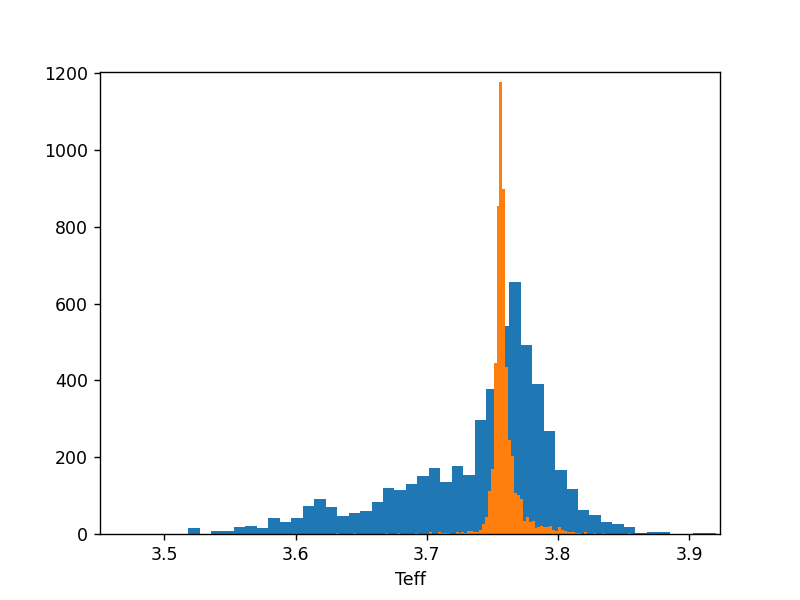

Text(0.5, 0, 'Teff')

In [210]:

plt.hist((np.log10(catalog.teff_val)), 50);
plt.hist(np.log10(catalog.teff_val)-T_eff_NN + 3.75, 500);
plt.xlabel('Teff')

<IPython.core.display.Javascript object>


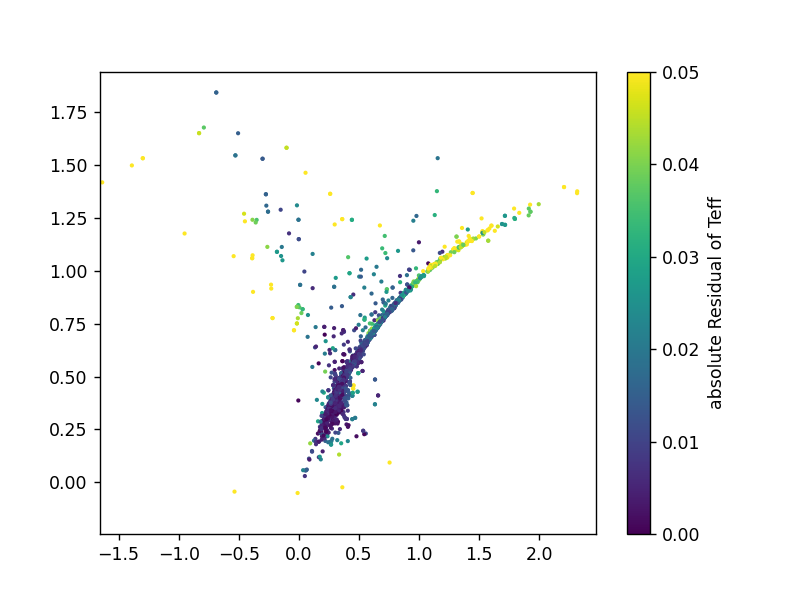

In [247]:
residual = np.log10(catalog.teff_val)-T_eff_NN
plt.scatter(catalog.bp_g, catalog.g_rp, c=abs(np.log10(catalog.teff_val)-T_eff_NN),vmin=0, vmax=0.05, s=2)
plt.colorbar(label='absolute Residual of Teff')


In [313]:
plt.scatter(np.log10(catalog.teff_val),T_eff_NN, c=catalog.bp_g, s=2, alpha=0.3)
plt.colorbar(label='bp_g')
plt.plot(np.arange(3.5,4,0.1), np.arange(3.5,4,0.1), c='red')
plt.xlabel('real catalog Teff')
plt.ylabel('computed Teff')

<IPython.core.display.Javascript object>

Text(0, 0.5, 'computed Teff')

In [168]:
NN = []
for star_ind in range(len(catalog)):
    if (pd.isnull(catalog.bp_g[star_ind]) or pd.isnull(catalog.g_rp[star_ind])):
        NN.append(np.nan)
    else:
        distance = (catalog.bp_g[star_ind] - BP_G_isoc[isoc_MS])**2 + (catalog.g_rp[star_ind] - G_RP_isoc[isoc_MS])**2
        nearest_ind = np.argmin(distance)
        NN.append(nearest_ind)

<IPython.core.display.Javascript object>


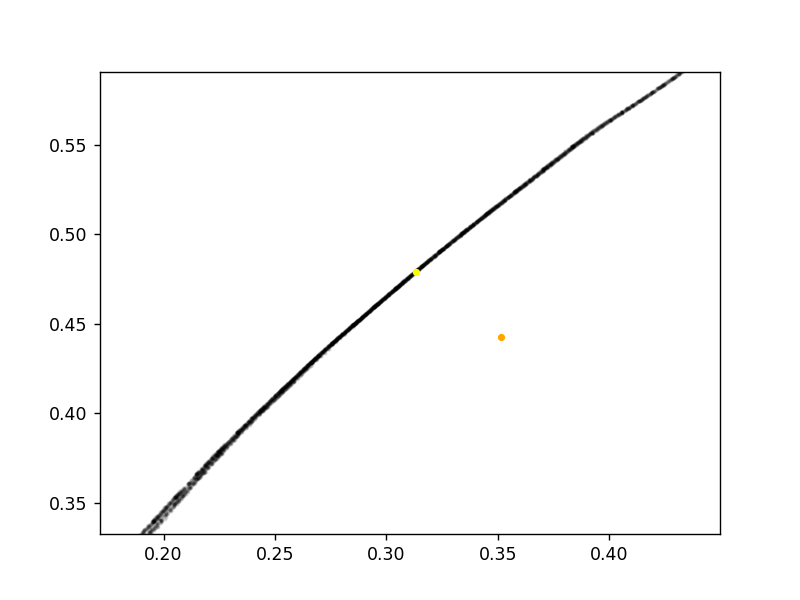

In [327]:


belowgap = np.where((np.array(L_NN) < 0) & (np.array(L_NN) > -0.1))[0]
i = belowgap[3]
plt.scatter(BP_G_isoc[isoc_MS], G_RP_isoc[isoc_MS], c='black', alpha=0.1, s=2)
plt.scatter(np.array(BP_G_isoc[isoc_MS])[NN[i]], np.array(G_RP_isoc[isoc_MS])[NN[i]], s=10, c='yellow')
plt.scatter(catalog.bp_g[i], catalog.g_rp[i], s=10,c='orange')

## Computing Luminosity

In [241]:
L_isoc =isoc.log_L
L_NN = []
for star_ind in range(len(catalog)):
    if (pd.isnull(catalog.bp_g[star_ind]) or pd.isnull(catalog.g_rp[star_ind])):
        L_NN.append(np.nan)
    else:
        distance = (catalog.bp_g[star_ind] - BP_G_isoc[isoc_MS])**2 + (catalog.g_rp[star_ind] - G_RP_isoc[isoc_MS])**2
        nearest_ind = np.argmin(distance)
        L_value = np.array(L_isoc[isoc_MS])[nearest_ind]
        L_NN.append(L_value)

<IPython.core.display.Javascript object>


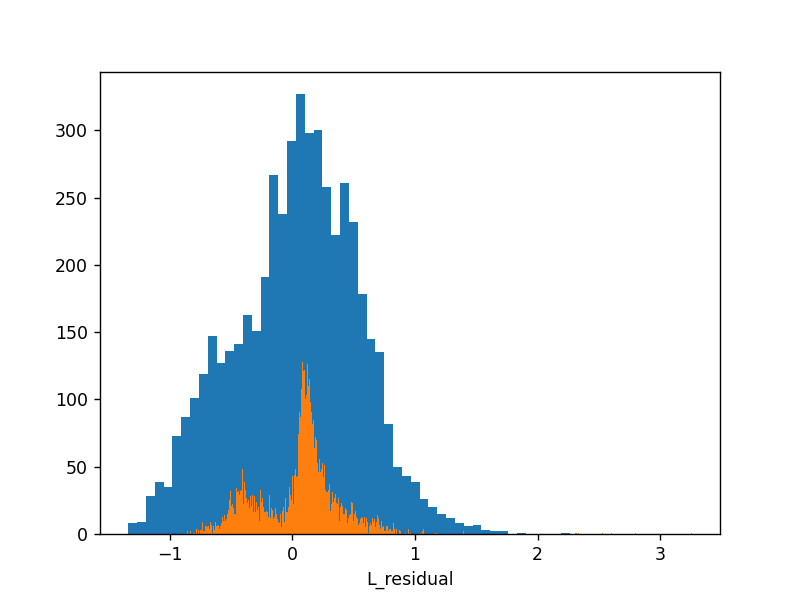

Text(0.5, 0, 'L_residual')

In [244]:
plt.hist((np.log10(catalog.lum_val)), 50);
plt.hist(np.log10(catalog.lum_val)-L_NN, 500);
plt.xlabel('L_residual')

In [256]:
residual_L = np.log10(catalog.lum_val)-L_NN
plt.scatter(catalog.bp_g, catalog.g_rp, c=abs(residual_L),vmin=0, vmax=0.5, s=2)
plt.colorbar(label='absolute Residual of L')

<IPython.core.display.Javascript object>

In [273]:
np.std(residual_L)

0.33301674083131133

In [325]:
%matplotlib notebook

<IPython.core.display.Javascript object>


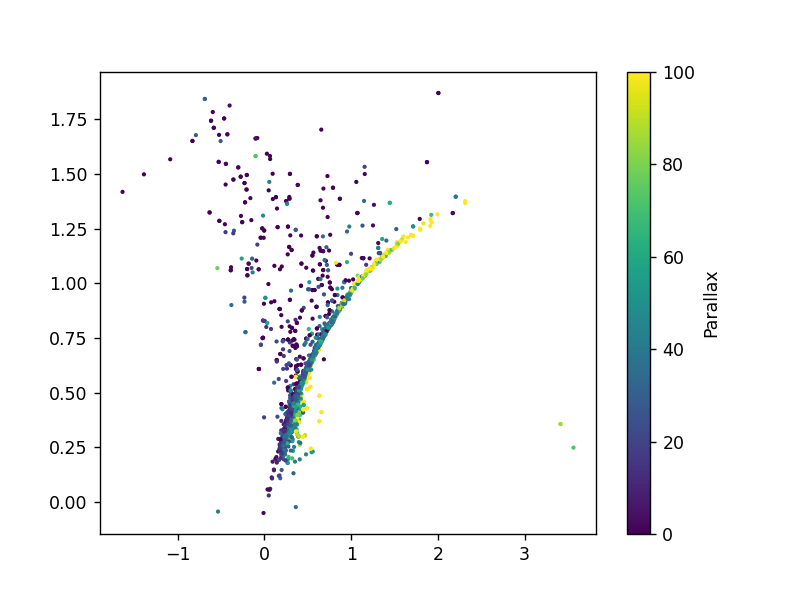

In [262]:
plt.scatter(catalog.bp_g, catalog.g_rp, c=catalog.parallax,vmin=0, vmax=100, s=2)
plt.colorbar(label='Parallax')

<IPython.core.display.Javascript object>


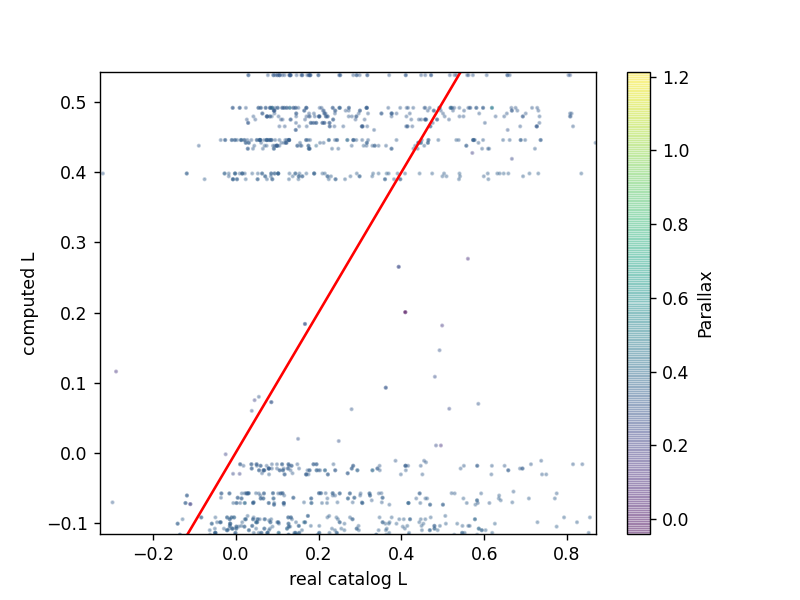

Text(0, 0.5, 'computed L')

In [314]:
plt.scatter(np.log10(catalog.lum_val),L_NN, c=catalog.bp_g, s=2, alpha=0.3)
plt.colorbar(label='Parallax')
plt.plot(np.arange(-1,1.5,0.1), np.arange(-1,1.5,0.1), c='red')
plt.xlabel('real catalog L')
plt.ylabel('computed L')

<IPython.core.display.Javascript object>


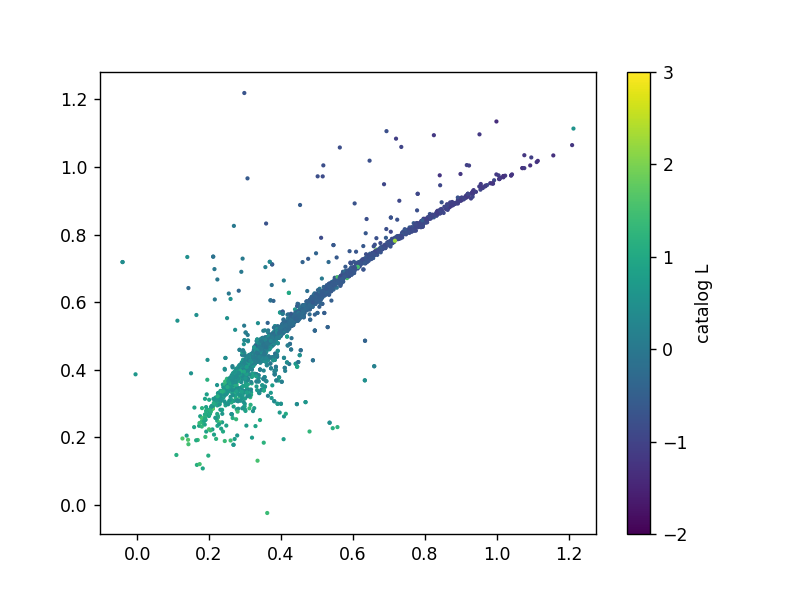

In [299]:

plt.scatter(catalog.bp_g, catalog.g_rp, c=np.log10(catalog.lum_val),vmin=-2, vmax=3, s=2)
plt.colorbar(label='catalog L')

<IPython.core.display.Javascript object>


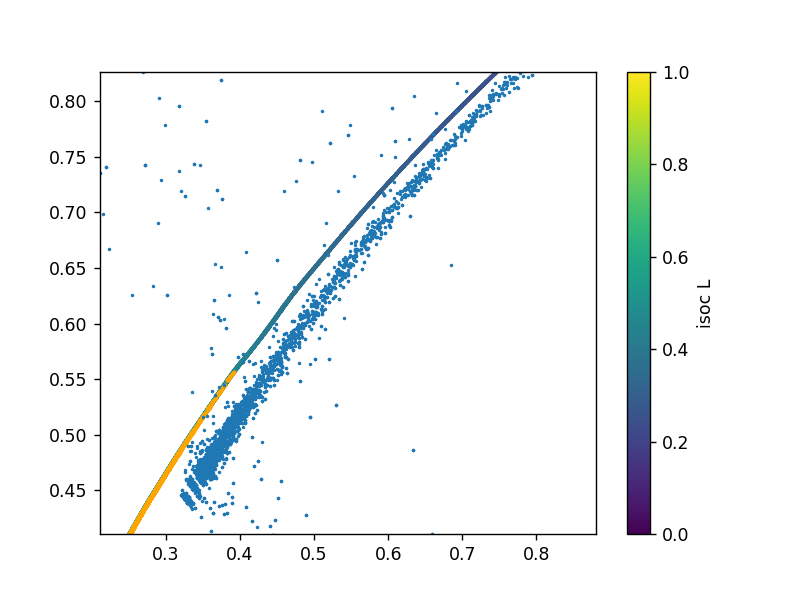

In [331]:
gap = np.where((isoc.log_L[isoc_MS]>0)&(isoc.log_L[isoc_MS]<0.4))[0]
plt.scatter(BP_G_isoc[isoc_MS], G_RP_isoc[isoc_MS], c=isoc.log_L[isoc_MS],vmin=-2, vmax=2, alpha=1, s=2)

plt.scatter(np.array(BP_G_isoc[isoc_MS])[gap], np.array(G_RP_isoc[isoc_MS])[gap], c='orange', alpha=1, s=2)

belowgap = np.where(np.array(L_NN) < 0)[0]
plt.scatter(catalog.bp_g[belowgap], catalog.g_rp[belowgap], s=1)
plt.colorbar(label='isoc L')

<IPython.core.display.Javascript object>


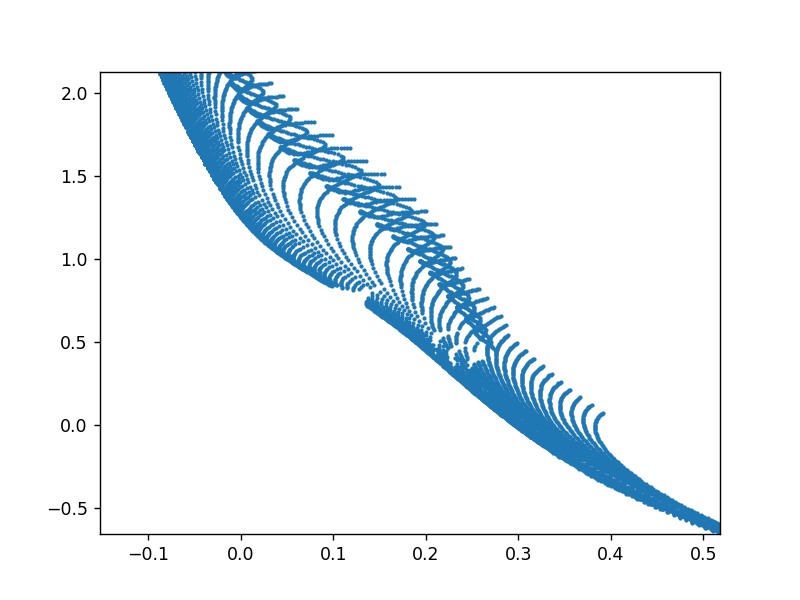

In [307]:
plt.scatter(BP_G_isoc[isoc_MS],isoc.log_L[isoc_MS], alpha=1, s=2)

In [318]:
np.array(isoc.log_L[isoc_MS])[np.where((isoc.log_L[isoc_MS]>0)&(isoc.log_L[isoc_MS]<0.4))[0]]

array([0.37447721, 0.39593283, 0.29031045, ..., 0.06146823, 0.06615984,
       0.07076077])